In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizerfrom keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
%cd '/content/drive/MyDrive/Project_DevC'
!ls

/content/drive/MyDrive/Project_DevC
 clone_cmt_tiki		    model.w2v
 clone_data		    scrapingweb_bookingcomment.ipynb
 Data_Bank100518.txt	   'Script - SơnNT.docx'
 Data_ChungKhoan14518.txt   Sentiment_Analysis.ipynb
 Data_chungkhoan_duc.csv    Sentiment_Lastest.ipynb
 data_dep.csv		    Sentiment_LSTM.ipynb
 datadepvail.csv	    stopwords.csv
 data.pkl		    Stopwords.ipynb
 Data_Preprocessing.ipynb   tokenizer.pkl
 encoder.pkl		    vietnamese-stopwords.csv
 model.h5		   'Xử lí dữ liệu + LSTM.pptx'


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["comment", "label"]
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 20
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
dataset_path = r"./Data_chungkhoan_duc.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path)

Open file: ./Data_chungkhoan_duc.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 5462


In [7]:
df = df.drop(['Unnamed: 0'],axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462 entries, 0 to 5461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5462 non-null   object
 1   label   5462 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.5+ KB


In [9]:
df.head(5)

,text,label
0,Fpt tăng đẹp quá. Kk,2
1,Tch tăng trần 2 phiên sau tin này rồi,2
2,Em bổ xung KBC vào danh mục khuyến nghị mua nh...,2
3,Cvt tiếp tục tăng tốt,2
4,HCM giảm mạnh rồi :D,0


In [10]:
decode_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
df.label = df.label.apply(lambda x: decode_sentiment(x))

In [12]:
def preprocess(text):
    # Loai bo cac ki tu dac biet, chuyen cau ve lower case
    return re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()

In [13]:
df.text = df.text.apply(lambda x: preprocess(x))

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 4369
TEST size: 1093


In [15]:
# Word2vec
documents = [_text.split() for _text in df_train.text] 

In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [17]:
w2v_model.build_vocab(documents)

2020-11-30 21:50:25,350 : INFO : collecting all words and their counts
2020-11-30 21:50:25,354 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-30 21:50:25,390 : INFO : collected 5817 word types from a corpus of 285562 raw words and 4369 sentences
2020-11-30 21:50:25,390 : INFO : Loading a fresh vocabulary
2020-11-30 21:50:25,395 : INFO : effective_min_count=10 retains 656 unique words (11% of original 5817, drops 5161)
2020-11-30 21:50:25,396 : INFO : effective_min_count=10 leaves 275252 word corpus (96% of original 285562, drops 10310)
2020-11-30 21:50:25,400 : INFO : deleting the raw counts dictionary of 5817 items
2020-11-30 21:50:25,401 : INFO : sample=0.001 downsamples 39 most-common words
2020-11-30 21:50:25,402 : INFO : downsampling leaves estimated 99143 word corpus (36.0% of prior 275252)
2020-11-30 21:50:25,406 : INFO : estimated required memory for 656 words and 300 dimensions: 1902400 bytes
2020-11-30 21:50:25,409 : INFO : resetting layer 

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 656


In [19]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-30 21:50:25,548 : INFO : training model with 8 workers on 656 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-30 21:50:25,754 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-30 21:50:25,755 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-30 21:50:25,765 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-30 21:50:25,775 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-30 21:50:25,779 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-30 21:50:25,784 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-30 21:50:25,786 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-30 21:50:25,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-30 21:50:25,796 : INFO : EPOCH - 1 : training on 285562 raw words (98984 effective words) took 0.2s, 432560 effectiv

CPU times: user 12.9 s, sys: 213 ms, total: 13.1 s
Wall time: 7.45 s


(3171191, 9137984)

In [20]:
#w2v_model.most_similar("")

In [21]:
#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 5818
CPU times: user 149 ms, sys: 887 µs, total: 150 ms
Wall time: 155 ms


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 170 ms, sys: 2.92 ms, total: 173 ms
Wall time: 174 ms


In [23]:
labels = df_train.label.unique().tolist()
labels

['POSITIVE', 'NEUTRAL', 'NEGATIVE']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (4369, 1)
y_test (1093, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4369, 300)
y_train (4369, 1)

x_test (1093, 300)
y_test (1093, 1)


In [26]:
y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)

In [27]:
#Embedding
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(5818, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences= True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

2020-11-30 21:50:34,306 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2020-11-30 21:50:34,604 : WARNING : Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1745400   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 256)          570368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,841,851
Trainable params: 1,096,451
Non-trainable params: 1,745,400
_________________________________________________________________


In [30]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [31]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
            EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/20
16/16 [==============================] - 32s 2s/step - loss: 0.8968 - accuracy: 0.6223 - val_loss: 0.7512 - val_accuracy: 0.6819
Epoch 2/20
16/16 [==============================] - 30s 2s/step - loss: 0.7596 - accuracy: 0.6907 - val_loss: 0.6902 - val_accuracy: 0.7231
Epoch 3/20
16/16 [==============================] - 30s 2s/step - loss: 0.6922 - accuracy: 0.7228 - val_loss: 0.6652 - val_accuracy: 0.7460
Epoch 4/20
16/16 [==============================] - 30s 2s/step - loss: 0.6482 - accuracy: 0.7431 - val_loss: 0.6170 - val_accuracy: 0.7414
Epoch 5/20
16/16 [==============================] - 30s 2s/step - loss: 0.6350 - accuracy: 0.7421 - val_loss: 0.6272 - val_accuracy: 0.7368
Epoch 6/20
16/16 [==============================] - 30s 2s/step - loss: 0.6305 - accuracy: 0.7505 - val_loss: 0.6155 - val_accuracy: 0.7506
Epoch 7/20
16/16 [==============================] - 31s 2s/step - loss: 0.5926 - accuracy: 0.7520 - val_loss: 0.6373 - val_accuracy: 0.7323
Epoch 8/20
16/16 [==

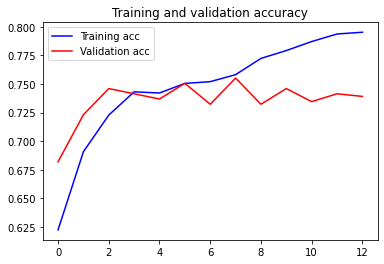

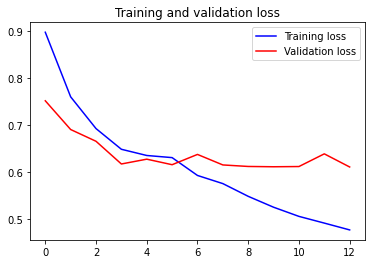

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [37]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 74.75%


In [38]:
y_pred = model.predict(x_test)
y_pred= np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test,axis = 1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.15      0.23       123
           1       0.81      0.87      0.84       713
           2       0.62      0.68      0.65       257

    accuracy                           0.75      1093
   macro avg       0.63      0.57      0.57      1093
weighted avg       0.73      0.75      0.73      1093



In [39]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

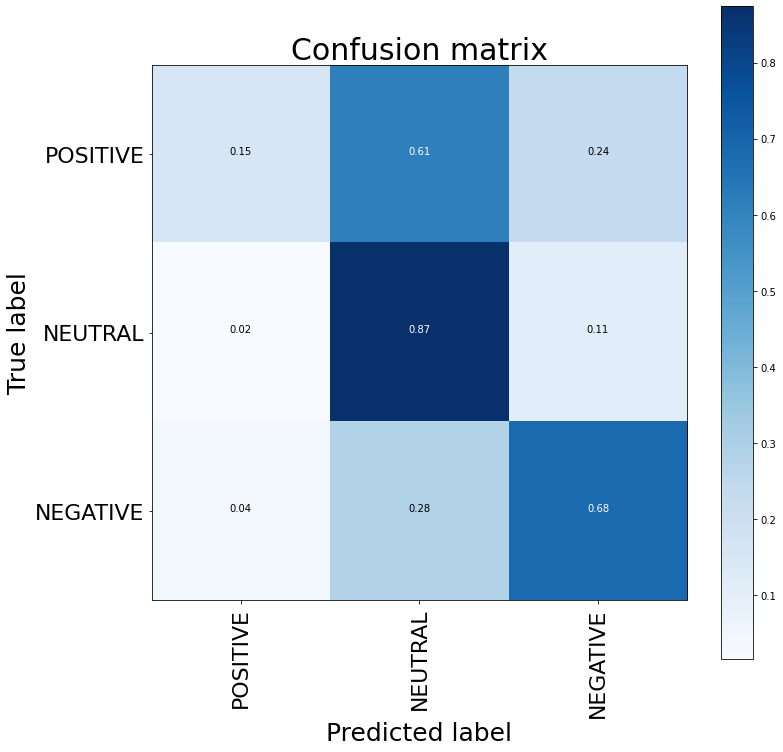

In [40]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.label.unique(), title="Confusion matrix")
plt.show()

In [41]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-30 21:57:51,098 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-30 21:57:51,101 : INFO : not storing attribute vectors_norm
2020-11-30 21:57:51,104 : INFO : not storing attribute cum_table
2020-11-30 21:57:51,133 : INFO : saved model.w2v
